# Connect colab to your google drive

In [ ]:
# Connect to your google drive
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/F1 Tenth

/content/drive/My Drive/F1 Tenth


In [ ]:
# !unzip f110_dataset_20220209.zip

# Useful tools:

In [ ]:
import torch
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn

def DisplayImage(img):
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    # image = np.transpose(image.copy(), (1, 2, 0))
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    plt.show()

def DisplayLabel(img, bboxs):
    # image = np.transpose(image.copy(), (1, 2, 0))
    # fig, ax = plt.subplots(1, figsize=(6, 8))
    image = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    edgecolor = [1, 0, 0]
    if len(bboxs) == 1:
        bbox = bboxs[0]
        ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    elif len(bboxs) > 1:
        for bbox in bboxs:
            ax.add_patch(patches.Rectangle((bbox[0] - bbox[2]/2, bbox[1] - bbox[3]/2), bbox[2], bbox[3], linewidth=1, edgecolor=edgecolor, facecolor='none'))
    ax.imshow(image)
    plt.show()


# Load data:

In [ ]:
dataset_folder = 'f110_dataset_20220209/'
path = dataset_folder + "labels.npy" 
labels = np.load(path)
print(len(labels))

1792


In [ ]:
final_dim = [5, 10]
input_dim = [180, 320]
anchor_size = [(input_dim[0] / final_dim[0]), (input_dim[1] / final_dim[1])]
arr = np.arange(labels.shape[0])
np.random.shuffle(arr)

# convert feature map coord to image coord
def grid_cell(cell_indx, cell_indy):
    stride_0 = anchor_size[1]
    stride_1 = anchor_size[0]
    return np.array([cell_indx * stride_0, cell_indy * stride_1, cell_indx * stride_0 + stride_0, cell_indy * stride_1 + stride_1])

# convert from [c_x, c_y, w, h] to [x_l, y_l, x_r, y_r]
def bbox_convert(c_x, c_y, w, h):
    return [c_x - w/2, c_y - h/2, c_x + w/2, c_y + h/2]

# convert from [x_l, y_l, x_r, x_r] to [c_x, c_y, w, h]
def bbox_convert_r(x_l, y_l, x_r, y_r):
    return [x_l/2 + x_r/2, y_l/2 + y_r/2, x_r - x_l, y_r - y_l]

# calculating IoU
def IoU(a, b):
    # referring to IoU algorithm in slides
    inter_w = max(0, min(a[2], b[2]) - max(a[0], b[0]))
    inter_h = max(0, min(a[3], b[3]) - max(a[1], b[1]))
    inter_ab = inter_w * inter_h
    area_a = (a[3] - a[1]) * (a[2] - a[0])
    area_b = (b[3] - b[1]) * (b[2] - b[0])
    union_ab = area_a + area_b - inter_ab
    return inter_ab / union_ab

def assign_label(label):
    label_gt = np.zeros((5, final_dim[0], final_dim[1]))
    IoU_threshold = 0.01
    IoU_max = 0
    IoU_max_ind = [0, 0]

    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            label_assign = 0
            grid_info = grid_cell(ind_col, ind_row)
            label_bbox = bbox_convert(label[0], label[1], label[2], label[3])
            IoU_value = IoU(label_bbox, grid_info)
            if IoU_value > IoU_threshold:
                label_assign = 1
            if IoU_value > IoU_max:
                IoU_max = IoU_value
                IoU_max_ind[0] = ind_row
                IoU_max_ind[1] = ind_col

            # construct the gt vector
            if label_assign == 1:
                label_gt[0, ind_row, ind_col] = 1
                label_gt[1, ind_row, ind_col] = label[0] - (grid_info[0] + anchor_size[1]/2)
                label_gt[2, ind_row, ind_col] = label[1] - (grid_info[1] + anchor_size[0]/2)
                label_gt[3, ind_row, ind_col] = label[2] / float(input_dim[1])
                label_gt[4, ind_row, ind_col] = label[3] / float(input_dim[0])
    
    grid_info = grid_cell(IoU_max_ind[0], IoU_max_ind[1])
    label_gt[0, IoU_max_ind[0], IoU_max_ind[1]] = 1
    label_gt[1, IoU_max_ind[0], IoU_max_ind[1]] = label[0] - (grid_info[0] + anchor_size[1]/2)
    label_gt[2, IoU_max_ind[0], IoU_max_ind[1]] = label[1] - (grid_info[1] + anchor_size[0]/2)
    label_gt[3, IoU_max_ind[0], IoU_max_ind[1]] = label[2] / float(input_dim[1])
    label_gt[4, IoU_max_ind[0], IoU_max_ind[1]] = label[3] / float(input_dim[0])
    return label_gt

# Due to the small size of dataset, we preprocess them into memory to speed up training.
images = []
for ind in range(labels.shape[0]):
    img_path = dataset_folder + str(ind) + '.jpg'
    img = cv2.imread(img_path) / 255.0
    img = cv2.resize(img, (input_dim[1], input_dim[0]))
    images.append(img)

# Construct datasets
class F110Dataset(torch.utils.data.Dataset):
    def __init__(self, scope, folder, labels):
        self.folder = folder
        self.labels = labels
        self.data_ind1 = (np.floor(self.labels.shape[0] / 10) * scope[0]).astype(int)
        self.data_ind2 = (np.floor(self.labels.shape[0] / 10) * scope[1]).astype(int)

    def __len__(self):
        return self.data_ind2 - self.data_ind1

    def __getitem__(self, index):
        label = self.labels[arr[index]].copy() / (360.0 / input_dim[0])
        label_gt = np.asarray(assign_label(label))
        img_np = images[arr[index]]
        img_np = np.transpose(img_np, (2, 0, 1))
        
        return torch.from_numpy(img_np).type('torch.FloatTensor'), \
                torch.from_numpy(label_gt).type('torch.FloatTensor'), label

train_set = F110Dataset([0, 9.5], dataset_folder, labels)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=1, shuffle=True)
validation_set = F110Dataset([9.5, 10], dataset_folder, labels)
validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=True)

(3, 180, 320)
tensor([126.5000,  79.2500,  93.0000,  74.5000], dtype=torch.float64)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[126.5000,  79.2500,  93.0000,  74.5000]], dtype=torch.float64)


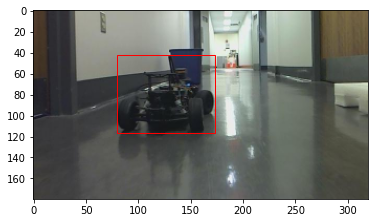

In [ ]:
## Plot one label to see if it's correct.

for data_ind, data_list in enumerate(train_loader):
    if data_ind == 0:
        image = data_list[0]
        label_gt = data_list[1]
        label = data_list[2]
        break
print(image[0].numpy().shape)
print(label[0])
print(label_gt[0][0])
print(label)
DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

# Model Definition

In [ ]:
class F110_YOLO(torch.nn.Module):
    def __init__(self):
        super(F110_YOLO, self).__init__()
        # TODO: Change the channel depth of each layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace = True)

        self.conv2 = nn.Conv2d(64, 128, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace = True)

        self.conv3 = nn.Conv2d(128, 256, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace = True)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU(inplace = True)

        self.conv5 = nn.Conv2d(512, 1024, kernel_size = 4, padding = 1, stride = 2)
        self.batchnorm5 = nn.BatchNorm2d(1024)
        self.relu5 = nn.ReLU(inplace = True)

        self.conv6 = nn.Conv2d(1024, 1024, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm6 = nn.BatchNorm2d(1024)
        self.relu6 = nn.ReLU(inplace = True)

        self.conv7 = nn.ConvTranspose2d(1024, 256, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm7 = nn.BatchNorm2d(256)
        self.relu7 = nn.ReLU(inplace = True)

        self.conv8 = nn.ConvTranspose2d(256, 64, kernel_size = 3, padding = 1, stride = 1)
        self.batchnorm8 = nn.BatchNorm2d(64)
        self.relu8 = nn.ReLU(inplace = True)

        self.conv9 = nn.Conv2d(64, 5, kernel_size = 1, padding = 0, stride = 1)
        self.relu9 = nn.ReLU()
    
    def forward(self, x):
        debug = 0 # change this to 1 if you want to check network dimensions
        if debug == 1: print(0, x.shape)
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        if debug == 1: print(1, x.shape)
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        if debug == 1: print(2, x.shape)
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        if debug == 1: print(3, x.shape)
        x = torch.relu(self.batchnorm4(self.conv4(x)))
        if debug == 1: print(4, x.shape)
        x = torch.relu(self.batchnorm5(self.conv5(x)))
        if debug == 1: print(5, x.shape)
        x = torch.relu(self.batchnorm6(self.conv6(x)))
        if debug == 1: print(6, x.shape)
        x = torch.relu(self.batchnorm7(self.conv7(x)))
        if debug == 1: print(7, x.shape)
        x = torch.relu(self.batchnorm8(self.conv8(x)))
        if debug == 1: print(8, x.shape)
        x = self.conv9(x)
        if debug == 1: print(9, x.shape)
        x = torch.cat([x[:, 0:3, :, :], torch.sigmoid(x[:, 3:5, :, :])], dim=1)

        return x

    def get_loss(self, result, truth, lambda_coord = 5, lambda_noobj = 1):
        x_loss = (result[:, 1, :, :] - truth[:, 1, :, :]) ** 2
        y_loss = (result[:, 2, :, :] - truth[:, 2, :, :]) ** 2
        w_loss = (torch.sqrt(result[:, 3, :, :]) - torch.sqrt(truth[:, 3, :, :])) ** 2
        h_loss = (torch.sqrt(result[:, 4, :, :]) - torch.sqrt(truth[:, 4, :, :])) ** 2
        class_loss_obj = truth[:, 0, :, :] * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2
        class_loss_noobj = (1 - truth[:, 0, :, :]) * lambda_noobj * (truth[:, 0, :, :] - result[:, 0, :, :]) ** 2

        total_loss = torch.sum(lambda_coord * truth[:, 0, :, :] * (x_loss + y_loss + w_loss + h_loss) + class_loss_obj + class_loss_noobj)
        
        return total_loss


# Train your network

Save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [ ]:
## Begin training the model
train_loss_record = []
validation_loss_record = []
device = torch.device('cuda')
model = F110_YOLO().to(device)

In [ ]:
## Training Process
batch_size = 10 # TODO: What batchsize is good? 1? 10? 100?
epochs = 20 # TODO: How many times should we train? 1? 10? 100?
lr = 0.01 # TODO: What learning rate is good? 1? 0.1? 0.01?

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.to(device)
    model.train()
    train_loss = []
    validation_loss = []
    # ind = 0

    time_train = 0
    for image_t, label_t, _ in train_loader:     
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        optimizer.zero_grad()
        
        result = model(image_t)
        loss = model.get_loss(result, label_t)
        
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/batch_size)        
    train_loss_record.append(np.average(train_loss))

    ## validationing
    model.eval()
    object_in_class = 0
    truth_in_class = 0
    for image_t, label_t, _ in validation_loader:
        image_t = image_t.to(device)
        label_t = label_t.to(device)
        result = model(image_t)
        loss = model.get_loss(result, label_t)
        validation_loss.append(loss.item())

    validation_loss_record.append(np.average(validation_loss))
    print("total epoch:", len(train_loss_record), '| train_loss:', np.average(train_loss), '| validation_loss:', np.average(validation_loss), )

# save the model
model_save_name = 'model_{}.pt'.format(len(train_loss_record))
path = "" + model_save_name
torch.save(model.state_dict(), path)

from tempfile import TemporaryFile
path = "loss_{}.npy".format(len(train_loss_record))
outfile = TemporaryFile()
np.save(path, [np.array(train_loss_record), np.array(validation_loss_record)])

total epoch: 1 | train_loss: 80750.7934742647 | validation_loss: 63299.269198947484
total epoch: 2 | train_loss: 28397.641757812504 | validation_loss: 23282.6407687717
total epoch: 3 | train_loss: 20915.253471966917 | validation_loss: 25159.83403184679
total epoch: 4 | train_loss: 16585.816838235292 | validation_loss: 14803.071970621744
total epoch: 5 | train_loss: 13971.028795955883 | validation_loss: 22510.550624932184
total epoch: 6 | train_loss: 12545.211399356616 | validation_loss: 8727.521007283529
total epoch: 7 | train_loss: 10375.725366498162 | validation_loss: 9015.82315504286
total epoch: 8 | train_loss: 8165.27867991728 | validation_loss: 8192.367204793294
total epoch: 9 | train_loss: 7630.582537913603 | validation_loss: 7810.834070078532
total epoch: 10 | train_loss: 5707.050199333639 | validation_loss: 5167.464739142524
total epoch: 11 | train_loss: 6271.260082720587 | validation_loss: 9044.264222039117
total epoch: 12 | train_loss: 7227.996981847427 | validation_loss: 47

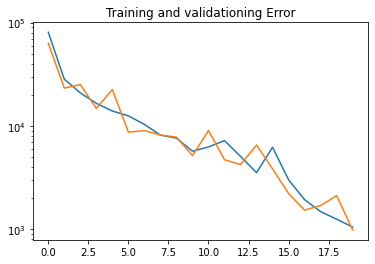

[988.6180964575874]
[1054.3876674517462]


In [ ]:
## Plot loss curves

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(train_loss_record)), train_loss_record, range(len(validation_loss_record)), validation_loss_record)
ax.set_yscale('log')
ax.set_title('Training and validationing Error')
plt.show()
print(validation_loss_record[-1:])
print(train_loss_record[-1:])

In [ ]:
## Converting label to bounding boxes

def label_to_box_xyxy(result, threshold = 0.9):
    validation_result = []
    result_prob = []
    for ind_row in range(final_dim[0]):
        for ind_col in range(final_dim[1]):
            grid_info = grid_cell(ind_col, ind_row)
            validation_result_cell = []
            if result[0, ind_row, ind_col] >= threshold:
                c_x = grid_info[0] + anchor_size[1]/2 + result[1, ind_row, ind_col]
                c_y = grid_info[1] + anchor_size[0]/2 + result[2, ind_row, ind_col]
                w = result[3, ind_row, ind_col] * input_dim[1]
                h = result[4, ind_row, ind_col] * input_dim[0]
                x1, y1, x2, y2 = bbox_convert(c_x, c_y, w, h)
                x1 = np.clip(x1, 0, input_dim[1])
                x2 = np.clip(x2, 0, input_dim[1])
                y1 = np.clip(y1, 0, input_dim[0])
                y2 = np.clip(y2, 0, input_dim[0])
                validation_result_cell.append(x1)
                validation_result_cell.append(y1)
                validation_result_cell.append(x2)
                validation_result_cell.append(y2)
                result_prob.append(result[0, ind_row, ind_col])
                validation_result.append(validation_result_cell)
    validation_result = np.array(validation_result)
    result_prob = np.array(result_prob)
    return validation_result, result_prob


def voting_suppression(result_box, iou_threshold = 0.5):
    votes = np.zeros(result_box.shape[0])
    for ind, box in enumerate(result_box):
        for box_validation in result_box:
            if IoU(box_validation, box) > iou_threshold:
                votes[ind] += 1
    return (-votes).argsort()


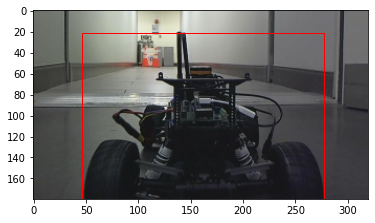

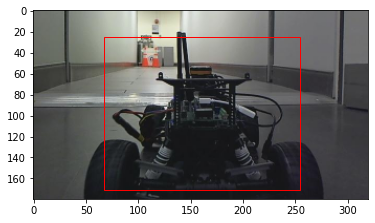

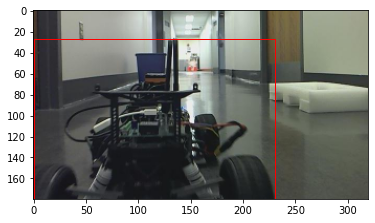

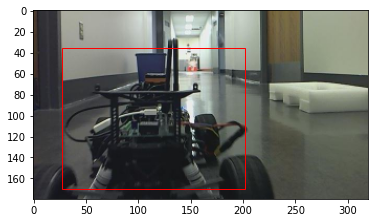

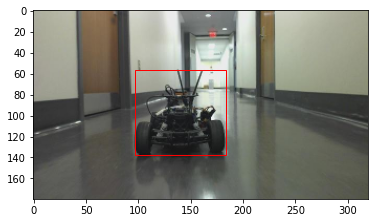

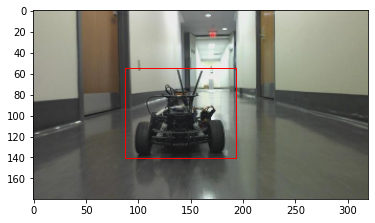

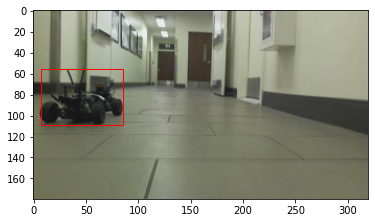

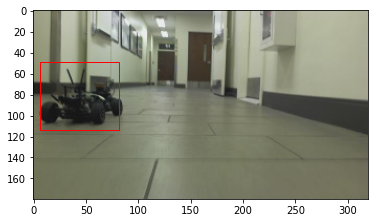

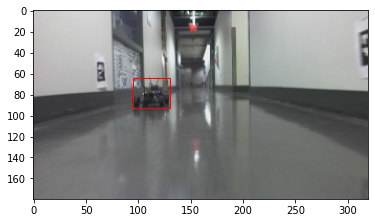

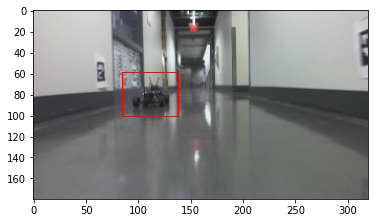

In [ ]:
## Display some images in the validation set

# validation_loader = torch.utils.data.DataLoader(dataset=validation_set, batch_size=1, shuffle=False)
for data_ind, data_list in enumerate(validation_loader):
    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]
    if data_ind == 5:
        break
    
    # display groud truth
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), label)

    # display detection
    voting_iou_threshold = 0.5
    confi_threshold = 0.4

    image_t = image.to(device)
    label_gt_t = label_gt.to(device)
    result = model(image_t)
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])
    DisplayLabel(np.transpose(image[0].numpy(), (1, 2, 0)), bboxs_2)


In [ ]:
## Calculate accuracy

model.eval()
object_in_class = 0
truth_in_class = 0
voting_iou_threshold = 0.5
confi_threshold = 0.5

for data_ind, data_list in enumerate(validation_loader):
    # print(data_ind)

    image = data_list[0]
    label_gt = data_list[1]
    label = data_list[2]

    result = model(image.to(device))
    result = result.detach().cpu().numpy()
    bboxs, result_prob = label_to_box_xyxy(result[0], confi_threshold)
    vote_rank = voting_suppression(bboxs, voting_iou_threshold)
    bbox = bboxs[vote_rank[0]]
    # prob = result_prob[vote_rank[0]]
    [c_x, c_y, w, h] = bbox_convert_r(bbox[0], bbox[1], bbox[2], bbox[3])
    bboxs_2 = np.array([[c_x, c_y, w, h]])

    pos_change = np.sqrt((label[0][0] - c_x) ** 2 + (label[0][1] - c_y) ** 2)
    x_l, y_l, x_r, y_r = bbox_convert(label[0][0], label[0][1], label[0][2], label[0][3])
    label_xxyy = [x_l, y_l, x_r, y_r]
    # print(label[0])
    # print(bboxs_2[0])
    # print(pos_change)
    if pos_change < 20 and IoU(bbox, label_xxyy) > 0.5:
        object_in_class += 1
    truth_in_class += 1

accuracy = object_in_class / truth_in_class

print('accuracy', accuracy)


<ipython-input-6-dd829fcbe09a>:30: RuntimeWarning: invalid value encountered in double_scalars
  return inter_ab / union_ab


accuracy 0.9111111111111111


In [ ]:
## load the model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = F110_YOLO()
model_save_name = 'model_20.pt'
path = F"/content/drive/My Drive/F1 Tenth/{model_save_name}"
model.load_state_dict(torch.load(path))
model = model.to(device)

path = F"/content/drive/My Drive/F1 Tenth/loss_20.npy" 
loss = np.load(path, allow_pickle=True)

Mounted at /content/drive


In [ ]:
!pip install albumentations==0.5.2

In [ ]:
import cv2
import torch
from albumentations import Resize, Compose
from albumentations.pytorch.transforms import  ToTensor
from albumentations.augmentations.transforms import Normalize
import numpy as np
 
def preprocess_image(img_path):
    # transformations for the input data
    transforms = Compose([
        Resize(224, 224, interpolation=cv2.INTER_NEAREST),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensor(),
    ])
     
    # read input image
    input_img = cv2.imread(img_path)
    # do transformations
    input_data = transforms(image=input_img)["image"]

    batch_data = torch.unsqueeze(input_data, 0)
    return batch_data
 

In [ ]:
input = preprocess_image("/content/drive/My Drive/F1 Tenth/test_car.png").cuda()
model.eval()
model.cuda()
output = model(input)
# print(output)

In [ ]:
ONNX_FILE_PATH = '/content/drive/My Drive/F1 Tenth/model.onnx'
torch.onnx.export(model, input, ONNX_FILE_PATH, input_names=['input'],
                  output_names=['output'], export_params=True)

In [ ]:
!pip install onnx

In [ ]:
import onnx
onnx_model = onnx.load(ONNX_FILE_PATH)
onnx.checker.check_model(onnx_model)

In [ ]:
!pip install pycuda
!pip install tensorrt

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import tensorrt as trt
 
# logger to capture errors, warnings, and other information during the build and inference phases
TRT_LOGGER = trt.Logger()
 
def build_engine(onnx_file_path):
    # initialize TensorRT engine and parse ONNX model
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network()
    parser = trt.OnnxParser(network, TRT_LOGGER)
     
    # parse ONNX
    with open(onnx_file_path, 'rb') as model:
        print('Beginning ONNX file parsing')
        parser.parse(model.read())
    print('Completed parsing of ONNX file')

    # allow TensorRT to use up to 1GB of GPU memory for tactic selection
    builder.max_workspace_size = 1 << 30
    # we have only one image in batch
    builder.max_batch_size = 1
    # use FP16 mode if possible
    if builder.platform_has_fast_fp16:
        builder.fp16_mode = True

    print('Building an engine...')
    engine = builder.build_cuda_engine(network)
    context = engine.create_execution_context()
    print("Completed creating Engine")
 
    return engine, context

In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import tensorrt as trt
 
# logger to capture errors, warnings, and other information during the build and inference phases
TRT_LOGGER = trt.Logger()
runtime = trt.Runtime
 
def build_engine(onnx_file_path):
    # initialize TensorRT engine and parse ONNX model
    builder = trt.Builder(TRT_LOGGER)
    network = builder.create_network()
    parser = trt.OnnxParser(network, TRT_LOGGER)
     
    # parse ONNX
    with open(onnx_file_path, 'rb') as model:
        print('Beginning ONNX file parsing')
        parser.parse(model.read())
    print('Completed parsing of ONNX file')

    # allow TensorRT to use up to 1GB of GPU memory for tactic selection
    config = builder.create_builder_config() 
    config.max_workspace_size = 1 << 28
    # builder.max_workspace_size = 1 << 30

    plan = builder.build_serialized_network(network, config) 
    
    # we have only one image in batch
    builder.max_batch_size = 64
    # use FP16 mode if possible
    #if builder.platform_has_fast_fp16:
        #builder.fp16_mode = True

    # generate TensorRT engine optimized for the target platform
    print('Building an engine...')
    # engine = builder.build_cuda_engine(network)
    engine = runtime.deserialize_cuda_engine(plan)
    context = engine.create_execution_context()
    print("Completed creating Engine")
    
    return engine, context

In [ ]:
ONNX_FILE_PATH = '/content/drive/MyDrive/F1 Tenth/model.onnx'
engine, context = build_engine(ONNX_FILE_PATH)

In [ ]:
# get sizes of input and output and allocate memory required for input data and for output data
for binding in engine:
    if engine.binding_is_input(binding):  # we expect only one input
        input_shape = engine.get_binding_shape(binding)
        input_size = trt.volume(input_shape) * engine.max_batch_size * np.dtype(np.float32).itemsize  # in bytes
        device_input = cuda.mem_alloc(input_size)
    else:  # and one output
        output_shape = engine.get_binding_shape(binding)
        # create page-locked memory buffers (i.e. won't be swapped to disk)
        host_output = cuda.pagelocked_empty(trt.volume(output_shape) * engine.max_batch_size, dtype=np.float32)
        device_output = cuda.mem_alloc(host_output.nbytes)

In [ ]:
BATCH_SIZE=64
import numpy as np
PRECISION = np.float32

from tensorrt import trtexec

trtexec --onnx=/content/drive/MyDrive/F1 Tenth/model.onnx --saveEngine=model_engine.trt

In [ ]:
!build trtexec

/bin/bash: build: command not found
